# Exploring precision and recall

The goal of this second notebook is to understand precision-recall in the context of classifiers.

 * Use Amazon review data in its entirety.
 * Train a logistic regression model.
 * Explore various evaluation metrics: accuracy, confusion matrix, precision, recall.
 * Explore how various metrics can be combined to produce a cost of making an error.
 * Explore precision and recall curves.
 
Because we are using the full Amazon review dataset (not a subset of words or reviews), in this assignment we return to using GraphLab Create for its efficiency. As usual, let's start by **firing up GraphLab Create**.

Make sure you have the latest version of GraphLab Create (1.8.3 or later). If you don't find the decision tree module, then you would need to upgrade graphlab-create using

```
   pip install graphlab-create --upgrade
```
See [this page](https://dato.com/download/) for detailed instructions on upgrading.

In [50]:
from __future__ import division
import numpy as np
import pandas as pd


# Load amazon review dataset

In [51]:
products = pd.read_csv('amazon_baby.csv')

# Extract word counts and sentiments

As in the first assignment of this course, we compute the word counts for individual words and extract positive and negative sentiments from ratings. To summarize, we perform the following:

1. Remove punctuation.
2. Remove reviews with "neutral" sentiment (rating 3).
3. Set reviews with rating 4 or more to be positive and those with 2 or less to be negative.

In [52]:
def remove_punctuation(text):
    import string
    text = "".join(l for l in text if l not in string.punctuation)
    return text

products = products.fillna({'review':''})  # fill in N/A's in the review column
# Remove punctuation.
products['review_clean'] = products['review'].apply(remove_punctuation)
# Count words
# products['word_count'] = products['review_clean'].apply(lambda x : len(x.split()))

# Drop neutral sentiment reviews.
products = products[products['rating'] != 3]

# Positive sentiment to +1 and negative sentiment to -1
products['sentiment'] = products['rating'].apply(lambda rating : +1 if rating > 3 else -1)

Now, let's remember what the dataset looks like by taking a quick peek:

In [53]:
products.head()

,name,review,rating,review_clean,sentiment
1,Planetwise Wipe Pouch,it came early and was not disappointed. i love...,5,it came early and was not disappointed i love ...,1
2,Annas Dream Full Quilt with 2 Shams,Very soft and comfortable and warmer than it l...,5,Very soft and comfortable and warmer than it l...,1
3,Stop Pacifier Sucking without tears with Thumb...,This is a product well worth the purchase. I ...,5,This is a product well worth the purchase I h...,1
4,Stop Pacifier Sucking without tears with Thumb...,All of my kids have cried non-stop when I trie...,5,All of my kids have cried nonstop when I tried...,1
5,Stop Pacifier Sucking without tears with Thumb...,"When the Binky Fairy came to our house, we did...",5,When the Binky Fairy came to our house we didn...,1


## Split data into training and test sets

We split the data into a 80-20 split where 80% is in the training set and 20% is in the test set.

In [54]:
import json
with open('module-9-assignment-train-idx.json', 'r') as f: 
    train_idx = json.load(f)
with open('module-9-assignment-test-idx.json', 'r') as f: 
    test_idx = json.load(f)

train_data = products.iloc[train_idx,:]
test_data = products.iloc[test_idx]

print('Training set   : %d data points' % len(train_data))
print('Validation set : %d data points' % len(test_data))

Training set   : 133416 data points
Validation set : 33336 data points


In [55]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(token_pattern=r'\b\w+\b')
     # Use this token pattern to keep single-letter words
# First, learn vocabulary from the training data and assign columns to words
# Then convert the training data into a sparse matrix
train_matrix = vectorizer.fit_transform(train_data['review_clean'])
# Second, convert the test data into a sparse matrix, using the same word-column mapping
test_matrix = vectorizer.transform(test_data['review_clean'])

## Train a logistic regression classifier

We will now train a logistic regression classifier with **sentiment** as the target and **word_count** as the features. We will set `validation_set=None` to make sure everyone gets exactly the same results.  

Remember, even though we now know how to implement logistic regression, we will use GraphLab Create for its efficiency at processing this Amazon dataset in its entirety.  The focus of this assignment is instead on the topic of precision and recall.

In [56]:
from sklearn.linear_model import LogisticRegression

model=LogisticRegression()
model.fit(train_matrix,train_data['sentiment'])


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

# Model Evaluation

We will explore the advanced model evaluation concepts that were discussed in the lectures.

## Accuracy

One performance metric we will use for our more advanced exploration is accuracy, which we have seen many times in past assignments.  Recall that the accuracy is given by

$$
\mbox{accuracy} = \frac{\mbox{# correctly classified data points}}{\mbox{# total data points}}
$$

To obtain the accuracy of our trained models using GraphLab Create, simply pass the option `metric='accuracy'` to the `evaluate` function. We compute the **accuracy** of our logistic regression model on the **test_data** as follows:

In [57]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_true=test_data['sentiment'].as_matrix(), y_pred=model.predict(test_matrix))
print("Test Accuracy: %s" % accuracy)

Test Accuracy: 0.932265418766


## Baseline: Majority class prediction

Recall from an earlier assignment that we used the **majority class classifier** as a baseline (i.e reference) model for a point of comparison with a more sophisticated classifier. The majority classifier model predicts the majority class for all data points. 

Typically, a good model should beat the majority class classifier. Since the majority class in this dataset is the positive class (i.e., there are more positive than negative reviews), the accuracy of the majority class classifier can be computed as follows:

In [58]:
baseline = len(test_data[test_data['sentiment'] == 1])/len(test_data)
print("Baseline accuracy (majority class classifier): %s" % baseline)

Baseline accuracy (majority class classifier): 0.8427825773938085


** Quiz Question:** Using accuracy as the evaluation metric, was our **logistic regression model** better than the baseline (majority class classifier)?

## Confusion Matrix

The accuracy, while convenient, does not tell the whole story. For a fuller picture, we turn to the **confusion matrix**. In the case of binary classification, the confusion matrix is a 2-by-2 matrix laying out correct and incorrect predictions made in each label as follows:
```
              +---------------------------------------------+
              |                Predicted label              |
              +----------------------+----------------------+
              |          (+1)        |         (-1)         |
+-------+-----+----------------------+----------------------+
| True  |(+1) | # of true positives  | # of false negatives |
| label +-----+----------------------+----------------------+
|       |(-1) | # of false positives | # of true negatives  |
+-------+-----+----------------------+----------------------+
```
To print out the confusion matrix for a classifier, use `metric='confusion_matrix'`:

In [59]:
from sklearn.metrics import confusion_matrix
cmat = confusion_matrix(y_true=test_data['sentiment'].as_matrix(),
                        y_pred=model.predict(test_matrix),
                        labels=model.classes_)    # use the same order of class as the LR model.
print(' target_label | predicted_label | count ')
print('--------------+-----------------+-------')
# Print out the confusion matrix.
# NOTE: Your tool may arrange entries in a different order. Consult appropriate manuals.
for i, target_label in enumerate(model.classes_):
    for j, predicted_label in enumerate(model.classes_):
        print('{0:^13} | {1:^15} | {2:5d}'.format(target_label, predicted_label, cmat[i,j]))

 target_label | predicted_label | count 
--------------+-----------------+-------
     -1       |       -1        |  3788
     -1       |        1        |  1453
      1       |       -1        |   805
      1       |        1        | 27290


**Quiz Question**: How many predicted values in the **test set** are **false positives**?

In [60]:
1453

805

## Computing the cost of mistakes


Put yourself in the shoes of a manufacturer that sells a baby product on Amazon.com and you want to monitor your product's reviews in order to respond to complaints.  Even a few negative reviews may generate a lot of bad publicity about the product. So you don't want to miss any reviews with negative sentiments --- you'd rather put up with false alarms about potentially negative reviews instead of missing negative reviews entirely. In other words, **false positives cost more than false negatives**. (It may be the other way around for other scenarios, but let's stick with the manufacturer's scenario for now.)

Suppose you know the costs involved in each kind of mistake: 
1. \$100 for each false positive.
2. \$1 for each false negative.
3. Correctly classified reviews incur no cost.

**Quiz Question**: Given the stipulation, what is the cost associated with the logistic regression classifier's performance on the **test set**?

In [90]:
1453*100+805*1

146105

## Precision and Recall

You may not have exact dollar amounts for each kind of mistake. Instead, you may simply prefer to reduce the percentage of false positives to be less than, say, 3.5% of all positive predictions. This is where **precision** comes in:

$$
[\text{precision}] = \frac{[\text{# positive data points with positive predicitions}]}{\text{[# all data points with positive predictions]}} = \frac{[\text{# true positives}]}{[\text{# true positives}] + [\text{# false positives}]}
$$

So to keep the percentage of false positives below 3.5% of positive predictions, we must raise the precision to 96.5% or higher. 

**First**, let us compute the precision of the logistic regression classifier on the **test_data**.

In [89]:
from sklearn.metrics import precision_score
precision = precision_score(y_true=test_data['sentiment'].as_matrix(), 
                            y_pred=model.predict(test_matrix))
print("Precision on test data: %s" % precision)

Precision on test data: 0.949448561389


**Quiz Question**: Out of all reviews in the **test set** that are predicted to be positive, what fraction of them are **false positives**? (Round to the second decimal place e.g. 0.25)

In [63]:
1-precision

0.050551438611140087

**Quiz Question:** Based on what we learned in lecture, if we wanted to reduce this fraction of false positives to be below 3.5%, we would: (see the quiz)

A complementary metric is **recall**, which measures the ratio between the number of true positives and that of (ground-truth) positive reviews:

$$
[\text{recall}] = \frac{[\text{# positive data points with positive predicitions}]}{\text{[# all positive data points]}} = \frac{[\text{# true positives}]}{[\text{# true positives}] + [\text{# false negatives}]}
$$

Let us compute the recall on the **test_data**.

In [64]:
from sklearn.metrics import recall_score
recall = recall_score(y_true=test_data['sentiment'].as_matrix(),
                      y_pred=model.predict(test_matrix))
print("Recall on test data: %s" % recall)

Recall on test data: 0.971347214807


**Quiz Question**: What fraction of the positive reviews in the **test_set** were correctly predicted as positive by the classifier?

**Quiz Question**: What is the recall value for a classifier that predicts **+1** for all data points in the **test_data**?

In [65]:
1.0

1.0

# Precision-recall tradeoff

In this part, we will explore the trade-off between precision and recall discussed in the lecture.  We first examine what happens when we use a different threshold value for making class predictions.  We then explore a range of threshold values and plot the associated precision-recall curve.  


## Varying the threshold

False positives are costly in our example, so we may want to be more conservative about making positive predictions. To achieve this, instead of thresholding class probabilities at 0.5, we can choose a higher threshold. 

Write a function called `apply_threshold` that accepts two things
* `probabilities` (an SArray of probability values)
* `threshold` (a float between 0 and 1).

The function should return an SArray, where each element is set to +1 or -1 depending whether the corresponding probability exceeds `threshold`.

In [66]:
def apply_threshold(probabilities, threshold):
    ### YOUR CODE GOES HERE
    # +1 if >= threshold and -1 otherwise.
    return np.array([+1 if x>threshold else -1 for x in probabilities])  

Run prediction with `output_type='probability'` to get the list of probability values. Then use thresholds set at 0.5 (default) and 0.9 to make predictions from these probability values.

In [67]:
probabilities = model.predict_proba(test_matrix)[:,1]
predictions_with_default_threshold = apply_threshold(probabilities, 0.5)
predictions_with_high_threshold = apply_threshold(probabilities, 0.9)

In [68]:
print("Number of positive predicted reviews (threshold = 0.5): %s" % (predictions_with_default_threshold == 1).sum())

Number of positive predicted reviews (threshold = 0.5): 28743


In [69]:
print("Number of positive predicted reviews (threshold = 0.9): %s" % (predictions_with_high_threshold == 1).sum())

Number of positive predicted reviews (threshold = 0.9): 25065


**Quiz Question**: What happens to the number of positive predicted reviews as the threshold increased from 0.5 to 0.9?

## Exploring the associated precision and recall as the threshold varies

By changing the probability threshold, it is possible to influence precision and recall. We can explore this as follows:

In [70]:
# Threshold = 0.5
precision_with_default_threshold = precision_score(y_true = test_data['sentiment'].as_matrix(), 
                                                   y_pred = predictions_with_default_threshold)

recall_with_default_threshold = recall_score(y_true = test_data['sentiment'].as_matrix(),
                                             y_pred = predictions_with_default_threshold)

# Threshold = 0.9
precision_with_high_threshold = precision_score(y_true = test_data['sentiment'].as_matrix(), 
                                        y_pred = predictions_with_high_threshold)
recall_with_high_threshold = recall_score(y_true = test_data['sentiment'].as_matrix(),
                                        y_pred = predictions_with_high_threshold)

In [71]:
print("Precision (threshold = 0.5): %s" % precision_with_default_threshold)
print("Recall (threshold = 0.5)   : %s" % recall_with_default_threshold)

Precision (threshold = 0.5): 0.949448561389
Recall (threshold = 0.5)   : 0.971347214807


In [72]:
print("Precision (threshold = 0.9): %s" % precision_with_high_threshold)
print("Recall (threshold = 0.9)   : %s" % recall_with_high_threshold)

Precision (threshold = 0.9): 0.981607819669
Recall (threshold = 0.9)   : 0.875743014771


**Quiz Question (variant 1)**: Does the **precision** increase with a higher threshold?

**Quiz Question (variant 2)**: Does the **recall** increase with a higher threshold?

## Precision-recall curve

Now, we will explore various different values of tresholds, compute the precision and recall scores, and then plot the precision-recall curve.

In [73]:
threshold_values = np.linspace(0.5, 0.999, num=100)
print(threshold_values)

[ 0.5         0.5050404   0.51008081  0.51512121  0.52016162  0.52520202
  0.53024242  0.53528283  0.54032323  0.54536364  0.55040404  0.55544444
  0.56048485  0.56552525  0.57056566  0.57560606  0.58064646  0.58568687
  0.59072727  0.59576768  0.60080808  0.60584848  0.61088889  0.61592929
  0.6209697   0.6260101   0.63105051  0.63609091  0.64113131  0.64617172
  0.65121212  0.65625253  0.66129293  0.66633333  0.67137374  0.67641414
  0.68145455  0.68649495  0.69153535  0.69657576  0.70161616  0.70665657
  0.71169697  0.71673737  0.72177778  0.72681818  0.73185859  0.73689899
  0.74193939  0.7469798   0.7520202   0.75706061  0.76210101  0.76714141
  0.77218182  0.77722222  0.78226263  0.78730303  0.79234343  0.79738384
  0.80242424  0.80746465  0.81250505  0.81754545  0.82258586  0.82762626
  0.83266667  0.83770707  0.84274747  0.84778788  0.85282828  0.85786869
  0.86290909  0.86794949  0.8729899   0.8780303   0.88307071  0.88811111
  0.89315152  0.89819192  0.90323232  0.90827273  0

For each of the values of threshold, we compute the precision and recall scores.

In [77]:
precision_all = []
recall_all = []

probabilities = model.predict_proba(test_matrix)[:,1]
for threshold in threshold_values:
    predictions = apply_threshold(probabilities, threshold)
    
    precision = precision_score(y_true = test_data['sentiment'].as_matrix(),y_pred = predictions)
    recall = recall_score(y_true = test_data['sentiment'].as_matrix(), y_pred = predictions)
    
    precision_all.append(precision)
    recall_all.append(recall)
    
precision_all=np.array(precision_all)
recall_all=np.array(recall_all)

print(precision_all)

[ 0.94944856  0.95001742  0.95046019  0.95091061  0.95139325  0.95181018
  0.95198629  0.95240262  0.95275287  0.95313869  0.9536238   0.95390718
  0.95419418  0.95443839  0.95485574  0.95526909  0.95554694  0.95589117
  0.95631137  0.95678314  0.9569942   0.95735034  0.95770703  0.95789586
  0.95825346  0.9585391   0.95912487  0.95964956  0.96014118  0.96066814
  0.96098328  0.96151783  0.96193239  0.96228715  0.96264801  0.96300686
  0.9633585   0.96377125  0.96415822  0.96462349  0.9648096   0.96504686
  0.96525992  0.96567987  0.96582904  0.96628846  0.96671159  0.96703497
  0.96774665  0.96812326  0.96838249  0.96880848  0.9691991   0.96966797
  0.9701988   0.97058171  0.97109121  0.97163094  0.97195602  0.97231731
  0.97350248  0.97390291  0.97414735  0.97450714  0.97493564  0.97540143
  0.97586968  0.97626226  0.97641618  0.97670944  0.9771051   0.97749171
  0.97799095  0.97849212  0.97907982  0.97963332  0.98005732  0.98044241
  0.98086068  0.98144018  0.981947    0.9826136   0

Now, let's plot the precision-recall curve to visualize the precision-recall tradeoff as we vary the threshold.

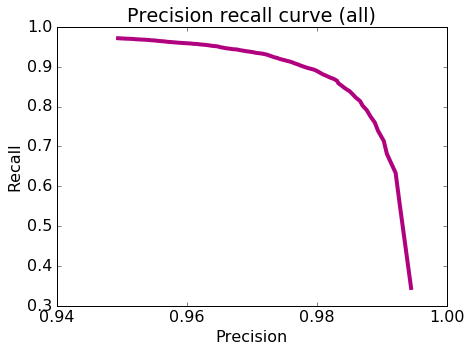

In [78]:
import matplotlib.pyplot as plt
%matplotlib inline

def plot_pr_curve(precision, recall, title):
    plt.rcParams['figure.figsize'] = 7, 5
    plt.locator_params(axis = 'x', nbins = 5)
    plt.plot(precision, recall, 'b-', linewidth=4.0, color = '#B0017F')
    plt.title(title)
    plt.xlabel('Precision')
    plt.ylabel('Recall')
    plt.rcParams.update({'font.size': 16})
    
plot_pr_curve(precision_all, recall_all, 'Precision recall curve (all)')

**Quiz Question**: Among all the threshold values tried, what is the **smallest** threshold value that achieves a precision of 96.5% or better? Round your answer to 3 decimal places.

In [79]:
print(threshold_values[precision_all>.965])

[ 0.70665657  0.71169697  0.71673737  0.72177778  0.72681818  0.73185859
  0.73689899  0.74193939  0.7469798   0.7520202   0.75706061  0.76210101
  0.76714141  0.77218182  0.77722222  0.78226263  0.78730303  0.79234343
  0.79738384  0.80242424  0.80746465  0.81250505  0.81754545  0.82258586
  0.82762626  0.83266667  0.83770707  0.84274747  0.84778788  0.85282828
  0.85786869  0.86290909  0.86794949  0.8729899   0.8780303   0.88307071
  0.88811111  0.89315152  0.89819192  0.90323232  0.90827273  0.91331313
  0.91835354  0.92339394  0.92843434  0.93347475  0.93851515  0.94355556
  0.94859596  0.95363636  0.95867677  0.96371717  0.96875758  0.97379798
  0.97883838  0.98387879  0.98891919  0.9939596   0.999     ]


**Quiz Question**: Using `threshold` = 0.98, how many **false negatives** do we get on the **test_data**? (**Hint**: You may use the `graphlab.evaluation.confusion_matrix` function implemented in GraphLab Create.)

In [80]:
predictions = apply_threshold(probabilities, 0.98)

cmat = confusion_matrix(y_true=test_data['sentiment'].as_matrix(),
                        y_pred=predictions,
                        labels=model.classes_)    # use the same order of class as the LR model.
print(' target_label | predicted_label | count ')
print('--------------+-----------------+-------')
# Print out the confusion matrix.
# NOTE: Your tool may arrange entries in a different order. Consult appropriate manuals.
for i, target_label in enumerate(model.classes_):
    for j, predicted_label in enumerate(model.classes_):
        print('{0:^13} | {1:^15} | {2:5d}'.format(target_label, predicted_label, cmat[i,j]))

 target_label | predicted_label | count 
--------------+-----------------+-------
     -1       |       -1        |  5050
     -1       |        1        |   191
      1       |       -1        |  8230
      1       |        1        | 19865


This is the number of false negatives (i.e the number of reviews to look at when not needed) that we have to deal with using this classifier.

# Evaluating specific search terms

So far, we looked at the number of false positives for the **entire test set**. In this section, let's select reviews using a specific search term and optimize the precision on these reviews only. After all, a manufacturer would be interested in tuning the false positive rate just for their products (the reviews they want to read) rather than that of the entire set of products on Amazon.

## Precision-Recall on all baby related items

From the **test set**, select all the reviews for all products with the word 'baby' in them.

In [81]:
baby_reviews = test_data[test_data['name'].apply(lambda x: 'baby' in str(x).lower())]

Now, let's predict the probability of classifying these reviews as positive:

In [82]:
baby_matrix = vectorizer.transform(baby_reviews['review_clean'])
probabilities = model.predict_proba(baby_matrix)[:,1]

Let's plot the precision-recall curve for the **baby_reviews** dataset.

**First**, let's consider the following `threshold_values` ranging from 0.5 to 1:

In [83]:
threshold_values = np.linspace(0.5, 0.999, num=100)

**Second**, as we did above, let's compute precision and recall for each value in `threshold_values` on the **baby_reviews** dataset.  Complete the code block below.

In [84]:
precision_all = []
recall_all = []

for threshold in threshold_values:
    
    # Make predictions. Use the `apply_threshold` function 
    ## YOUR CODE HERE 
    predictions = apply_threshold(probabilities, threshold)

    # Calculate the precision.
    # YOUR CODE HERE
    precision = precision_score(y_true = baby_reviews['sentiment'].as_matrix(),y_pred = predictions)
    
    # YOUR CODE HERE
    recall = recall_score(y_true = baby_reviews['sentiment'].as_matrix(),y_pred = predictions)
    
    # Append the precision and recall scores.
    precision_all.append(precision)
    recall_all.append(recall)
    
precision_all=np.array(precision_all)
recall_all=np.array(recall_all)

**Quiz Question**: Among all the threshold values tried, what is the **smallest** threshold value that achieves a precision of 96.5% or better for the reviews of data in **baby_reviews**? Round your answer to 3 decimal places.

In [85]:
print(threshold_values[precision_all>.965])

[ 0.73185859  0.73689899  0.74193939  0.7469798   0.7520202   0.75706061
  0.76210101  0.76714141  0.77218182  0.77722222  0.78226263  0.78730303
  0.79234343  0.79738384  0.80242424  0.80746465  0.81250505  0.81754545
  0.82258586  0.82762626  0.83266667  0.83770707  0.84274747  0.84778788
  0.85282828  0.85786869  0.86290909  0.86794949  0.8729899   0.8780303
  0.88307071  0.88811111  0.89315152  0.89819192  0.90323232  0.90827273
  0.91331313  0.91835354  0.92339394  0.92843434  0.93347475  0.93851515
  0.94355556  0.94859596  0.95363636  0.95867677  0.96371717  0.96875758
  0.97379798  0.97883838  0.98387879  0.98891919  0.9939596   0.999     ]


**Quiz Question:** Is this threshold value smaller or larger than the threshold used for the entire dataset to achieve the same specified precision of 96.5%?

**Finally**, let's plot the precision recall curve.

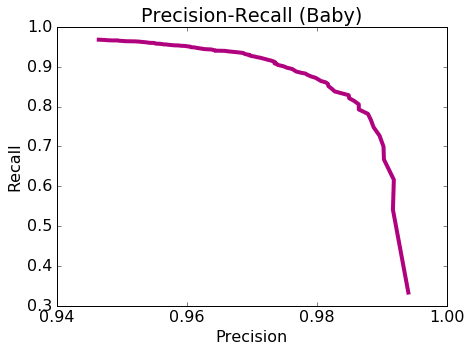

In [86]:
plot_pr_curve(precision_all, recall_all, "Precision-Recall (Baby)")